# 1.0 Importing Libraries

In [1]:
import plotly.express as px
import plotly.graph_objects as go
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from plot_utils import create_horizontal_bar_plot, create_vertical_bar_plot, create_box_plot
from plot_utils import create_horizontal_high_value_bar_plot
from plot_utils import create_vertical_high_value_bar_line_plot
from plot_utils import plot_top_quartile_and_sales
import statsmodels.api as sm
import numpy as np

In [2]:
pd.set_option('display.max_columns', 50)

# 2.0 Loading Data

In [3]:
df_sales_group = pd.read_csv('dataset/sales_group.csv')

author = pd.read_csv('dataset/author.csv')
award = pd.read_csv('dataset/award.csv')
book = pd.read_csv('dataset/book.csv')
edition = pd.read_csv('dataset/edition.csv')
format = pd.read_csv('dataset/format.csv')
genders = pd.read_csv('dataset/genders.csv')
info = pd.read_csv('dataset/info.csv')
publisher = pd.read_csv('dataset/publisher.csv')
ratings = pd.read_csv('dataset/ratings.csv')
series = pd.read_csv('dataset/series.csv')

### 2.1 Basic Data Transformation

In [4]:
# Renaming the columns on the award dataset to eliminate spaces
cols_new = ['book_id', 'title', 'award_name', 'year_won']
award.columns = cols_new

In [5]:
# Checking for duplicates
datasets = [author, award, book, edition, format, info, publisher, series, genders, ratings]
datasets_names = ['author', 'award', 'book', 'edition', 'format', 'info', 'publisher', 'series', 'genders', 'ratings']

i=0
for dataset in datasets:
    print(f'Dataset: {datasets_names[i]} - Quantidade de duplicadas: {dataset.duplicated().sum()}\n')
    i+=1

Dataset: author - Quantidade de duplicadas: 0

Dataset: award - Quantidade de duplicadas: 0

Dataset: book - Quantidade de duplicadas: 0

Dataset: edition - Quantidade de duplicadas: 0

Dataset: format - Quantidade de duplicadas: 0

Dataset: info - Quantidade de duplicadas: 0

Dataset: publisher - Quantidade de duplicadas: 119

Dataset: series - Quantidade de duplicadas: 0

Dataset: genders - Quantidade de duplicadas: 0

Dataset: ratings - Quantidade de duplicadas: 0



In [6]:
# Lets remove the duplicates from the publisher dataset
publisher.drop_duplicates(inplace=True)

### 2.2 Merging the datasets

In [7]:
df = pd.merge(book, author, how='left', on='author_id')
df = pd.merge(df, info, how='left', on='book_id')
df = pd.merge(df, series, how='left', on='series_id')
df = pd.merge(df, genders, how='left', on='genre_id')

#### 2.2.1 Award dataset

The award dataset has duplicated book_ids for books with multiple awards, lets aggregate them before merging

In [8]:
award_agg = award.groupby('book_id').agg({
    'title': 'first',
    'award_name': lambda x: ', '.join(x),
    'year_won': 'first'}).reset_index()

df = pd.merge(df, award_agg, how='left', on='book_id')

#### 2.2.2 Publisher dataset

The publisher dataset also has duplicated book_ids for books with multiple publishers. But, we have a problem that some publishers have two different pub_ids, so we can't merge them yet.

So, first we'll determine that the right pub_id is the one who corresponds to the initials of the publisher name.


In [9]:
# Defining useful functions

def get_initials(name):
    return "".join(word[0] for word in name.split()).upper()

def select_pub_id(group):
    initials = group["initials"].iloc[0]
    matching_pub_id = group[group["pub_id"] == initials]

    if not matching_pub_id.empty:
        return matching_pub_id.iloc[0]
    else:
        return group.sort_values("pub_id").iloc[0]


In [10]:
# Getting the initials of the publisher name
publisher["initials"] = publisher["name"].apply(get_initials)

# Selecting the correct pub_id
publisher_corrected = publisher.groupby(["book_id", "name"], group_keys=False).apply(select_pub_id)
publisher_corrected.reset_index(drop=True, inplace=True)

# Dropping the initial column
publisher_corrected = publisher_corrected.drop(columns=["initials"])
publisher = publisher.drop(columns=["initials"])

Now we can aggregate and merge the datasets.

In [11]:
# Merging the datasets
df = pd.merge(df, publisher_corrected, how='left', on='book_id')

#### 2.2.3 Ratings dataset

Let's keep only the average rating and the number of ratings for each book

In [12]:
# Getting the average rating
ratings_mean = ratings.groupby('book_id')['rating'].mean().round(2).reset_index()
ratings_mean.columns = ['book_id', 'rating_mean']

In [13]:
# Getting the number of ratings
ratings_count = ratings.groupby('book_id')['rating'].count().reset_index()
ratings_count.columns = ['book_id', 'rating_count']

In [14]:
# Merging the datasets
df = pd.merge(df, ratings_mean, how='left', on='book_id')
df = pd.merge(df, ratings_count, how='left', on='book_id')

#### 2.2.4 Edition dataset

Lets first merge the edition and the format datasets.

In [15]:
df_edition = pd.merge(edition, format, how='left', on='format_id')

In [16]:
df_edition.drop(columns=['format_id'], inplace=True)

#### 2.2.5 Sales dataset

In [17]:
sales = pd.merge(df_sales_group, df_edition, how='left', on='isbn')
# sales = pd.merge(sales, df, how='left', on=['book_id', 'pub_id'])

# 3.0 Data Transformation

Lets organize the data before merging into the sales dataset

In [18]:
# Getting the author name
df['author_name'] = df['first_name'] + ' ' + df['last_name']

## 3.1 Dataset columns

In [19]:
# Remove unuseful columns
df.drop(columns=['title_y', 'author_id', 'genre_id', 'series_id', 'first_name', 'last_name'], inplace=True)

In [20]:
# Renaming the columns
df.rename(columns={
    'title_x': 'title',
    'genre_desc': 'genre',
    'name': 'pub_name',
    'city': 'pub_city',
    'state': 'pub_state',
    'country': 'pub_country'
}, inplace=True)

In [21]:
sales.rename(columns={
    'COUNT': 'sales_count',
    'format_desc': 'format'
}, inplace=True)

## 3.2 Data types

In [22]:
# Checking the data types
df.dtypes

book_id               object
title                 object
birthday              object
country_residence     object
hrs_writing_day      float64
volume_number        float64
series_name           object
genre                 object
award_name            object
year_won             float64
pub_name              object
pub_city              object
pub_state             object
pub_country           object
year_established     float64
marketing_spend      float64
pub_id                object
rating_mean          float64
rating_count         float64
author_name           object
dtype: object

In [23]:
sales.dtypes

sale_date            object
isbn                 object
sales_count           int64
book_id              object
pub_id               object
publication_date     object
pages                 int64
print_run_size_k      int64
price               float64
format               object
dtype: object

In [24]:
# Transform from object to datetime
df['birthday'] = pd.to_datetime(df['birthday'], format='%d/%m/%Y')
sales['sale_date'] = pd.to_datetime(sales['sale_date'], format='%d/%m/%Y')
sales['publication_date'] = pd.to_datetime(sales['publication_date'], format='%d/%m/%Y')

In [25]:
# Transform from float to int
df['volume_number'] = df['volume_number'].astype('Int64')
df['year_won'] = df['year_won'].astype('Int64')
df['year_established'] = df['year_established'].astype('Int64')
df['marketing_spend'] = df['marketing_spend'].astype('Int64')
df['rating_count'] = df['rating_count'].astype('Int64')
sales['print_run_size_k'] = sales['print_run_size_k'].astype('Int64')
sales['pages'] = sales['pages'].astype('Int64')

## 3.3 Null values

In [26]:
# Checking for missing values
df.isnull().sum()

book_id               0
title                 0
birthday              0
country_residence     0
hrs_writing_day       0
volume_number        39
series_name          39
genre                 0
award_name           42
year_won             42
pub_name              1
pub_city              1
pub_state             1
pub_country           1
year_established      1
marketing_spend       1
pub_id                1
rating_mean           2
rating_count          2
author_name           0
dtype: int64

In [27]:
sales.isnull().sum()

sale_date           0
isbn                0
sales_count         0
book_id             0
pub_id              0
publication_date    0
pages               0
print_run_size_k    0
price               0
format              0
dtype: int64

In [28]:
# volume_number null values are the ones that don't have series
df['volume_number'].fillna(0, inplace=True)

# series_name null values are the ones that also don't have series
df['series_name'].fillna('', inplace=True)

# award_name and year_won null values are the ones that don't have awards, so let's keep them as NaN

# rating_count null values are the ones that don't have ratings
df['rating_count'].fillna(0, inplace=True)

# We have one book that doesn't have a publisher
# Let's keep the rating_mean null value as NaN to not affect the average rating


## 3.4 Check duplicates

In [29]:
df.duplicated().sum()

0

In [30]:
df['book_id'].duplicated().sum()

1

In [31]:
sales.duplicated().sum()

0

## 3.5 Creating sales by date per book dataset

In [32]:
print(f'The df dataset has information about {df.shape[0]} books and the following {df.shape[1]} columns:\n{list(i for i in df.columns)}')

The df dataset has information about 59 books and the following 20 columns:
['book_id', 'title', 'birthday', 'country_residence', 'hrs_writing_day', 'volume_number', 'series_name', 'genre', 'award_name', 'year_won', 'pub_name', 'pub_city', 'pub_state', 'pub_country', 'year_established', 'marketing_spend', 'pub_id', 'rating_mean', 'rating_count', 'author_name']


In [33]:
print(f'The sales dataset has information about {sales.shape[0]} sales and the following {sales.shape[1]} columns:\n{list(i for i in sales.columns)}')

The sales dataset has information about 15188 sales and the following 10 columns:
['sale_date', 'isbn', 'sales_count', 'book_id', 'pub_id', 'publication_date', 'pages', 'print_run_size_k', 'price', 'format']


Now we can finally merge the two datasets.

In [34]:
df_sales = pd.merge(sales, df, how='left', on=['book_id', 'pub_id'])

## 3.6 Creating sales per book dataset

In [35]:
# Create dataset with the total sales for each book
sales_per_book = df_sales.groupby('isbn').agg(total_sales=('sales_count', 'sum')).reset_index()

In [36]:
# Create dataset with the books info
book_info = df_sales.drop(columns=['sale_date', 'sales_count']).drop_duplicates()

In [37]:
# Merge the two datasets
sales_total = pd.merge(sales_per_book, book_info, how='left', on='isbn')

In [38]:
# Create a column for the total revenue for each book
sales_total['total_revenue'] = sales_total['total_sales'] * sales_total['price']

# 4.0 Exploratory Data Analysis

## 4.1 Analysing big numbers

Total invoice

In [39]:
value_to_display = sales_total['total_revenue'].sum()

# Convert value to thousands and format as USD
value_in_k = value_to_display / 1_000

In [40]:
# Create an indicator chart
fig = go.Figure(go.Indicator(
    mode="number", 
    value=value_in_k,
    title={"text": "Total Invoice"},
    number={"prefix": "USD ", "suffix": "K", "font": {"size": 48}},
    domain={"x": [0, 1], "y": [0, 1]}
))

# Update layout for better scaling
fig.update_layout(
    height=250,
    width=400,
    template='plotly_white'
)

# Show the chart
fig.show()

Total sales

In [41]:
value_to_display = sales_total['total_sales'].sum()

# Convert value to thousands
value_in_k = value_to_display / 1_000

# Create an indicator chart
fig = go.Figure(go.Indicator(
    mode="number", 
    value=value_in_k,
    title={"text": "Total Sales Count"},
    number={"prefix": "", "suffix": "K", "font": {"size": 48}},
    domain={"x": [0, 1], "y": [0, 1]}
))

# Update layout for better scaling
fig.update_layout(
    height=250,
    width=400,
    template='plotly_white'
)

# Show the chart    
fig.show()

Number of unique book titles

In [42]:
value_to_display = sales_total['title'].nunique()

# Create an indicator chart
fig = go.Figure(go.Indicator(
    mode="number", 
    value=value_to_display,
    title={"text": "Unique Book Titles"},
    number={"prefix": "", "font": {"size": 48}},
    domain={"x": [0, 1], "y": [0, 1]}
))

# Update layout for better scaling 
fig.update_layout(
    height=250,
    width=400,
    template='plotly_white'
)

# Show the chart
fig.show()

## 4.2 Overview

### 4.2.1 Genre distribution

In [43]:
create_vertical_bar_plot(sales_total, 'genre')

### 4.2.2 Publisher distribution

In [44]:
create_vertical_bar_plot(sales_total, 'pub_name', 'Publisher distribution')

We note that there are only 4 publishers in the dataset and the one with the highest amount of books is Etaoin Shrdlu Press (ESP)

### 4.2.3 Format distribution

In [45]:
create_horizontal_bar_plot(sales_total, 'format')

The most common book format is Hardcover.

### 4.2.4 Author distribution

In [46]:
create_horizontal_bar_plot(sales_total, 'author_name', 'Books per author distribution')

### 4.2.5 Price distribution

In [47]:
price_distribution = sales_total.price.describe()

In [48]:
print(f'The average price of a book is ${price_distribution["mean"]:.2f} and the standard deviation is ${price_distribution["std"]:.2f}')
print(f'The minimum price is ${price_distribution["min"]:.2f} and the maximum price is ${price_distribution["max"]:.2f}')

The average price of a book is $16.84 and the standard deviation is $8.47
The minimum price is $5.99 and the maximum price is $48.00


In [49]:
create_box_plot(sales_total, 'price')

We have only one outlier with a price of $48.

### 4.2.6 Pages distribution

In [50]:
pages_distribution = sales_total.pages.describe()
print(f'The average number of pages is {pages_distribution["mean"].round(0)} and the standard deviation is {pages_distribution["std"]:.2f}')
print(f'The minimum number of pages is {pages_distribution["min"].round(0)} and the maximum number of pages is {pages_distribution["max"].round(0)}')

The average number of pages is 387.0 and the standard deviation is 252.85
The minimum number of pages is 11.0 and the maximum number of pages is 1296.0


In [51]:
create_box_plot(sales_total, 'pages')

### 4.2.7 Geographical distribution

In [52]:
create_horizontal_bar_plot(sales_total, 'country_residence', "Author's country of residence distribution")

In [53]:
# Let's plot the country distribution for the publishers in the dataset
df_plot = sales_total.groupby('pub_country').agg(
    Count=('pub_country', 'count'),
    Publishers=('pub_name', lambda x: ", ".join(sorted(set(x))))
).reset_index()

df_plot.columns = ['pub_country'.replace('_', ' ').title(), 'Count', 'Publishers']
df_plot = df_plot.sort_values('Count', ascending=False)

fig = px.bar(
    df_plot,
    x=df_plot.columns[0],
    y=df_plot.columns[1],
    text=df_plot["Publishers"],
    title=f"Publisher's country distribution",
    color_discrete_sequence=['seagreen']
)

fig.update_traces(textposition="outside")
fig.update_layout(
    template='plotly_white',
    title_font_size=16,
    xaxis_title=df_plot.columns[0],
    yaxis_title='Count',
    height=600,
    width=800
)

fig.show()

## 4.3 Top Sellers

### 4.3.1 Best-selling and most profitable books

In [54]:
create_horizontal_high_value_bar_plot(sales_total, 'title', 'total_sales', quantile=0.9)

In [55]:
create_horizontal_high_value_bar_plot(sales_total, 'title', 'total_revenue', quantile=0.9)

We see that our top 3 🏆 Best-selling books are:

1. The Mallemaroking
2. Portmeirion
3. Heliotrope Pajamas

And our 💵 Most Profitable books are:

1. The Mallemaroking
2. Rystwyth
3. Portmeirion

### 4.3.2 Most Profitable Authors

In [56]:
create_horizontal_high_value_bar_plot(sales_total, 'author_name', 'total_revenue')

In [57]:
books_from_bianca = sales_total[sales_total['author_name'] == 'Bianca Thompson']['title'].unique()
print(f'Our most profitable author is Bianca Thompson and her books are: {books_from_bianca}')

Our most profitable author is Bianca Thompson and her books are: ['The Mallemaroking' 'Portmeirion' 'Rystwyth']


### 4.3.3 Most profitable genres

Lets plot the total sales for each genre, but also the sales normalized by the number of books in each genre.

In [58]:
create_vertical_high_value_bar_line_plot(sales_total, 'genre', 'total_sales')

Mistery books have a higher percentage of sales in relation to the quantity offered than those in the SciFi/Fantasy genre (our top-seller)

In [59]:
create_vertical_high_value_bar_line_plot(sales_total, 'genre', 'total_revenue')

### 4.3.4 Most profitable format

In [60]:
create_vertical_high_value_bar_line_plot(sales_total, 'format', 'total_sales', legend_pos=[0.95, 0.85])

### 4.3.5 Most profitable publishers

In [61]:
create_vertical_high_value_bar_line_plot(sales_total, 'pub_name', 'total_revenue')

In [62]:
create_vertical_high_value_bar_line_plot(sales_total, 'pub_name', 'total_sales')

## 4.4 Insights

### 4.4.1 Correlation beetween good reviews and total sales

In [63]:
# First, lets analyse the ratings distribution
create_box_plot(sales_total, 'rating_mean')

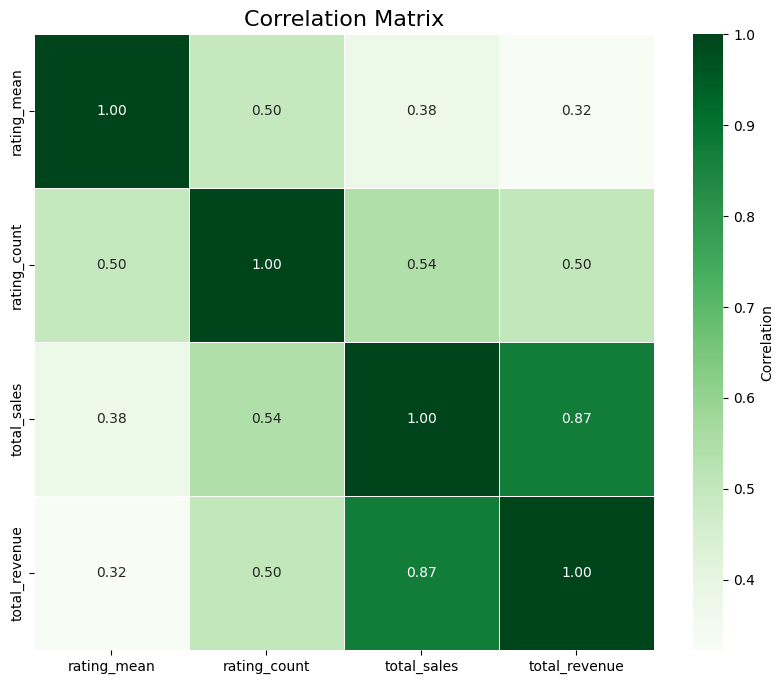

In [64]:
# Now, lets see the correlation between the ratings and the sales
correlation_matrix = sales_total[['rating_mean', 'rating_count', 'total_sales', 'total_revenue']].corr(method='pearson')

plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt=".2f",
    cmap='Greens',
    cbar_kws={'label':'Correlation'},
    linewidths=0.5
)

plt.title('Correlation Matrix', fontsize=16)
plt.show()

Here we see that rating_mean has a high correlation with both total_sales and total_revenue. Futhermore, we see that rating_count has an even stronger correlation.

Let's analyse books that have a high rating but a low invoice.

In [65]:
df_ratings = sales_total.groupby('title', as_index=False).agg({
    'rating_mean': 'mean',
    'rating_count': 'sum',
    'total_sales': 'sum',
    'total_revenue': 'sum'
}
)

In [66]:
plot_top_quartile_and_sales(df_ratings, 'total_sales', 'rating_mean')

Here we can see that some books have a high rating but a low invoice. We can make some specific promotions to increase their selling rate.

### 4.4.2 Prize winner books

In [67]:
sales_total['award_winner'] = sales_total['award_name'].notnull().astype(int)

In [68]:
# Lets plot a pizza chart to see how many books won awards

awards_count = sales_total['award_winner'].value_counts().reset_index()
awards_count['award_winner'] = awards_count['award_winner'].map({0: 'No', 1: 'Yes'})

fig = px.pie(
    values=awards_count['count'],
    names=awards_count['award_winner'],
    title='Award Winners Distribution',
    template='plotly_white',
    color=awards_count['award_winner'],
    color_discrete_map={'No': 'seagreen', 'Yes': 'yellowgreen'}
)

fig.update_traces(textposition='inside', textinfo='percent+label')

fig.update_layout(
    template='plotly_white',
    title_font_size=16,
    height=600,
    width=600,
    legend_title_text='Award Winner'
)

fig.show()

In [69]:
# Now lets plot a bar chart for the average income for books that won awards

awards_count = sales_total.groupby('award_winner').agg({'total_revenue': 'mean'}).reset_index()
awards_count['award_winner'] = awards_count['award_winner'].map({0: 'No', 1: 'Yes'})

fig = px.bar(
    awards_count,
    x='award_winner',
    y='total_revenue',
    title='Average Revenue for Award Winners and Non-Winner Books',
    template='plotly_white',
    color='award_winner',
    color_discrete_map={'No': 'seagreen', 'Yes': 'yellowgreen'},
    text_auto='.3s'
)

fig.update_layout(
    template='plotly_white',
    title_font_size=16,
    xaxis_title='Award Winner',
    yaxis_title='Average Revenue',
    height=600,
    width=800,
    showlegend=False
)

fig.show()

### 4.4.3 Marketing spend and sales

In [70]:
sales_total.marketing_spend.value_counts()

marketing_spend
2320000    49
48000      19
72000      18
151000      7
Name: count, dtype: Int64

In [71]:
sales_total['marketing_spend'].describe()

count              93.0
mean      1257473.11828
std      1127613.395352
min             48000.0
25%             72000.0
50%           2320000.0
75%           2320000.0
max           2320000.0
Name: marketing_spend, dtype: Float64

In [72]:
correlation_marketing = sales_total[['marketing_spend', 'total_revenue']].corr(method='pearson').iloc[0,1]

print(f'The correlation between the marketing spend and the total revenue is {correlation_marketing:.2f}')

The correlation between the marketing spend and the total revenue is 0.23


In [73]:
# Lets add a column for the ROI (Return on Investment)
sales_total['ROI'] = (sales_total['total_revenue'] - sales_total['marketing_spend']) / sales_total['marketing_spend']

In [74]:
fig = px.histogram(
    sales_total,
    x='ROI',
    title='Distribution of ROI',
    template='plotly_white',
    color_discrete_sequence=['seagreen']
)

fig.update_layout(
    template='plotly_white',
    title_font_size=16,
    xaxis_title='ROI',
    yaxis_title='Count',
    height=600,
    width=800
)

fig.show()

Here we see that all the books have a negative ROI. That means that the revenue generated by the book is less than the marketing spend.

### 4.4.4 Price distribution

In [75]:
# Creating price ranges
bins = [0, 10, 20, 30, 50]
labels = ['0-10', '10-20', '20-30', '30-50']
sales_total['price_bin'] = pd.cut(sales_total['price'], bins=bins, labels=labels, right=False)

# Grouping sales by price range as percentages
sales_by_price_bin = sales_total.groupby('price_bin', observed=False)['total_sales'].sum()
total_sales_count = sales_by_price_bin.sum()
sales_by_price_bin_percentage = (sales_by_price_bin / total_sales_count) * 100

# Grouping invoice by price range as percentages
invoice_by_price_bin = sales_total.groupby('price_bin', observed=False)['total_revenue'].sum()
total_invoice_count = invoice_by_price_bin.sum()
invoice_by_price_bin_percentage = (invoice_by_price_bin / total_invoice_count) * 100

In [76]:
# Plotting the sales count percentage by price range
fig = go.Figure()

fig.add_trace(go.Bar(
    x=sales_by_price_bin_percentage.index.astype(str),
    y=sales_by_price_bin_percentage,
    name='Sales count percentage',
    marker_color='seagreen',
    text=[f'{value:.2f}%' for value in sales_by_price_bin_percentage],
    textposition='outside'
))

fig.update_layout(
    title='Sales count percentage by price range',
    xaxis_title='Price range',
    yaxis_title='Total Sales Parcentage (%)',
    template='plotly_white',
    height=600,
    width=800
)

fig.show()

In [77]:
# Plotting the invoice count percentage by price range
fig = go.Figure()

fig.add_trace(go.Bar(
    x=invoice_by_price_bin_percentage.index.astype(str),
    y=invoice_by_price_bin_percentage,
    name='Invoice count percentage',
    marker_color='seagreen',
    text=[f'{value:.2f}%' for value in invoice_by_price_bin_percentage],
    textposition='outside'
))

fig.update_layout(
    title='Invoice count percentage by price range',
    xaxis_title='Price range',
    yaxis_title='Total Invoice Parcentage (%)',
    template='plotly_white',
    height=600,
    width=800
)

fig.show()

The growth campains should focus on the 20-30 price range.

### 4.4.5 Price optimization

To measure the impact of a promotional campaign, we can calculate the price elasticity of demand. This is the ratio of the change in sales to the change in price.

```math
\text{Elasticity} = \frac{\%\Delta \text{Sales}}{\%\Delta \text{Price}}
```

We will transform our sales data into a log scale to make it more linear and help us estimate the elasticity more accurately.

In [78]:
sales_total['log_price'] = np.log(sales_total['price'])
sales_total['log_sales'] = np.log(sales_total['total_sales'])

In [79]:
# Before running the regression, lets plot the relationship between price and sales
fig = px.scatter(
    sales_total,
    x='log_price',
    y='log_sales',
    title='Log of Sales vs Log of Price',
    template='plotly_white',
    color_discrete_sequence=['seagreen']
)

fig.update_layout(
    template='plotly_white',
    title_font_size=20,
    xaxis_title='Log of Price',
    yaxis_title='Log of Sales',
    height=700,
    width=700,
    plot_bgcolor='lightgray'
)

fig.update_traces(marker=dict(size=10))

fig.show()

We can see a negative relationship between price and sales. As expected, as the price goes up, the sales go down. But to measure the magnitude of the relationship, lets calculate the elasticity.

In [80]:
X = sm.add_constant(sales_total['log_price'])
model = sm.OLS(sales_total['log_sales'], X).fit()
elasticity = model.params['log_price']

print(f'Elasticity: {elasticity:.2f}')

Elasticity: -1.91


Now we can analyse the effect of some discounts on the sales. Já que
```math
\text{Elasticity} = \frac{\%\Delta \text{Sales}}{\%\Delta \text{Price}},
```
temos que:
```math
\text{Sales}_{new} = \text{Sales}_{before} \times (1+\text{Elasticity} \times \text{discount})
```	

In [81]:
# Now we can analyse the effect of some discounts on the sales
discounts = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7]

results = []
for d in discounts:
    sales_total['new_price'] = sales_total['price'] * (1 - d)
    sales_total['new_sales'] = sales_total['total_sales']* (1+elasticity*(-d))

    sales_total['new_total_revenue'] = sales_total['new_price'] * sales_total['new_sales']

    atual_invoice = sales_total['total_revenue'].sum()
    invoice_discount = sales_total['new_total_revenue'].sum()
    percentage = (invoice_discount - atual_invoice) / atual_invoice * 100

    results.append((d, atual_invoice.round(2), invoice_discount.round(2), percentage.round(2)))


results_df = pd.DataFrame(results, columns=['Discount', 'Current Invoice', 'Invoice with discount', 'Percentage Gain (%)'])
results_df

,Discount,Current Invoice,Invoice with discount,Percentage Gain (%)
0,0.05,699885.48,728394.52,4.07
1,0.10,699885.48,750219.00,7.19
2,0.15,699885.48,765358.92,9.35
3,0.20,699885.48,773814.28,10.56
4,0.25,699885.48,775585.08,10.82
5,0.30,699885.48,770671.33,10.11
6,0.40,699885.48,740790.13,5.84
7,0.50,699885.48,684170.71,-2.25
8,0.60,699885.48,600813.04,-14.16
9,0.70,699885.48,490717.13,-29.89


In [82]:
max_index = results_df['Percentage Gain (%)'].idxmax()
max_discount = results_df.loc[max_index, 'Discount']
max_gain = results_df.loc[max_index, 'Percentage Gain (%)']
max_invoice = results_df.loc[max_index, 'Invoice with discount']
max_invoice_current = results_df.loc[max_index, 'Current Invoice']

In [83]:
# Now lets plot the effect of discounts on sales

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=results_df['Discount'],
    y=results_df['Percentage Gain (%)'],
    mode='markers',
    name='Percentage Gain (%)',
    marker_color='seagreen',
    text=[f'{value:.2f}%' for value in results_df['Percentage Gain (%)']],
    textposition='top center'
))

fig.update_traces(marker=dict(size=10))

fig.add_trace(go.Scatter(
    x=[max_discount],
    y=[max_gain],
    mode='markers+text',
    name='Max Gain',
    marker=dict(color='crimson', size=14, symbol='star'),
    text=[f'<b>Discount:</b> {max_discount:.0%} - <b>Max Gain: </b>{max_gain:.2f}%'],
    textposition='top center',
    textfont=dict(size=11, color='crimson')
))

fig.update_layout(
    title='Effect of Discounts on Sales',
    xaxis_title='Discount',
    yaxis_title='Percentage Gain on Sales (%)',
    title_font_size=20,
    template='plotly_white',
    height=600,
    width=800,
    showlegend=False
)

fig.show()

In [84]:
print(f'The maximum percentage gain on sales is {max_gain:.2f}% with a discount of {max_discount:.0%}.')
print(f'Assuming we are dealing with dollars, this means that we would have a total invoice of \033[1m${max_invoice:.0f}\033[0m instead of \033[1m${max_invoice_current:.0f}\033[0m. A gain of ${max_invoice - max_invoice_current:.0f}.')

The maximum percentage gain on sales is 10.82% with a discount of 25%.
Assuming we are dealing with dollars, this means that we would have a total invoice of $775585 instead of $699885. A gain of $75700.


It is important to emphasize that here we are using a simple linear regression in order to show the growth potential hidden in the data, but in a realistic scenario, other variables must be taken into account. 

The OLS method is simple and easy to interpret, but it can be biased if there is endogeneity in the data, i.e. price and sales are influenced by something in common, such as seasonality or marketing.

In a future analysis, other more robust methods could be used to obtain an estimate of demand reaction that is closer to reality.

### 4.4.6 Sazonality Analysis

In [85]:
first_date = df_sales['sale_date'].min()
last_date = df_sales['sale_date'].max()

print(f'The interval of sales is from {first_date.strftime("%Y-%m-%d")} to {last_date.strftime("%Y-%m-%d")}')

The interval of sales is from 2193-01-02 to 2193-12-31


#### 4.4.6.1 Daily Sales

In [86]:
# Agregate sales by day

daily_sales = df_sales.groupby('sale_date')['sales_count'].sum().reset_index()

fig = px.line(
    daily_sales,
    x='sale_date',
    y='sales_count',
    title='Daily Sales',
    template='plotly_white',
    markers=True
)

fig.update_traces(
    line_color='seagreen',
)

fig.update_layout(
    title_font_size=20,
    xaxis_title='Date',
    yaxis_title='Total Sales',
    xaxis_title_font_size=16,
    yaxis_title_font_size=16,
    height=700,
    width=1400,
    xaxis_tickformat="%d-%m-%Y",
    hovermode='x unified',
    xaxis=dict(nticks=14)
)

fig.show()

#### 4.4.6.2 Monthly Sales

In [87]:
# Agregate the sales by month

df_sales['month'] = df_sales['sale_date'].dt.month_name()

monthly_sales = df_sales.groupby('month', sort=False)['sales_count'].sum().reset_index()

In [88]:
fig = px.bar(
    monthly_sales,
    x='month',
    y='sales_count',
    title='Monthly Sales',
    template='plotly_white',
    text='sales_count',
    text_auto='.2s'
)

fig.update_traces(
    marker_color='seagreen'
)

fig.update_layout(
    title_font_size=20,
    xaxis_title='Month',
    yaxis_title='Total Sales',
    xaxis_title_font_size=16,
    yaxis_title_font_size=16,
    height=600,
    width=800
)

fig.show()

#### 4.4.6.3 Weekly Sales

In [89]:
# Agregate the sales by week

df_sales['week'] = df_sales['sale_date'].dt.day_name()

weekly_sales = df_sales.groupby('week', sort=False)['sales_count'].sum().reset_index()

week_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekly_sales['week'] = pd.Categorical(weekly_sales['week'], categories=week_order, ordered=True)
weekly_sales = weekly_sales.sort_values('week')

In [90]:
fig = px.bar(
    weekly_sales,
    x='week',
    y='sales_count',
    title='Weekly Sales',
    template='plotly_white',
    text='sales_count',
    text_auto='.2s'
)

fig.update_traces(
    marker_color='seagreen'
)

fig.update_layout(
    title_font_size=20,
    xaxis_title='Weekday',
    yaxis_title='Total Sales',
    xaxis_title_font_size=16,
    yaxis_title_font_size=16,
    height=600,
    width=800
)

fig.show()

# 5.0 Export data for report 

In [91]:
sales_total.to_csv('dataset/sales_total.csv', index=False, encoding='utf-8')

df_sales.to_csv('dataset/df_sales.csv', index=False, encoding='utf-8')